One method for approximating option prices which are based on the Black-Scholes model is to replace the Brownian motion by a discrete-time simple random walk. This approximation breaks up the interval $[0, t_0]$ into $[0, t_0/n, \dots, (n - 1)t_0/n, t_0]$ and assumes that between the times $it_0/n$ and $(i + 1)t_0/n$, $i = 0, \dots, n - 1$, the increment in the logarithm of the price is $g$ or $-g$ with probability $p$ or $1 - p$ respectively, where $g$ and $p$ are chosen so that the increment has mean $\mu t_0/n$ and variance $\sigma^2 t_0/n$.

This approximation is of interest for cases such as the American put where exact formulae are not available. For a European (or American) call option, the price obtained from the random walk will approximate the true price obtained from the Black-Scholes formula, and this can be a useful benchmark to judge the performance of the approximation.

One way to implement the approximation is to set
\begin{equation}
    V_{i,j} = (pV_{i+1,j+1} + (1 - p)V_{i+1,j})e^{−\rho t_0/n} \quad \text{for} \quad j = 0, \dots, i \quad \text{and} \quad i = n − 1, \dots, 0
\end{equation}
with boundary conditions
\begin{equation}
    V_{n,j} = (S_0e^{(2j−n)g} − c)^+ \quad \text{for} \quad j = 0, \dots, n.
\end{equation}
Then $V_{0,0}$ is the approximate price.

To find $g$ and $p$ as functions of the model's parameters, we need to set up and solve a system of two equations based on the given information about the mean and variance of the logarithmic price increment.

Let the Bernoulli random variable $X$ represent the increment in the logarithm of the price over a small time interval $t_0/n$. Then
*   $X$ can take the value $g$ with probability $p$.
*   $X$ can take the value $-g$ with probability $1-p$.
*   The mean of this increment is $E[X] = \mu t_0/n$.
*   The variance of this increment is $Var(X) = \sigma^2 t_0/n$.

The expected value of $X$ is given by
\begin{equation}
    E[X] = (gp) + (-g(1 - p)) = g(2p - 1),
\end{equation}
and the second moment of $X$ is
\begin{equation}
    E[X²] = (g^2p) + ((-g)^2(1 - p)) = g^2,
\end{equation}
which gives the variance
\begin{equation}
    Var(X) = g^2 - (E[X])^2 = g^2 - g^2(2p - 1)^2 = g^2p(4 - 4p).
\end{equation}
We have the equations
\begin{equation}
    g(2p - 1) = \mu t_0/n, \\
    4g^2p(1 - p) = \sigma^2 t_0/n.
\end{equation}
Solving for g:
which we can solve for $g > 0$,
\begin{equation}
    g = \sqrt{(\sigma^2t_0/n) + (\mu t_0/n)^2}.
\end{equation}
Now we solve for $p$,
\begin{equation}
    p = \frac{1}{2}\left(1 + \frac{\mu t_0/n}{g}\right) = \frac{1}{2} \left(1 + \frac{\mu t_0/n}{\sqrt{ (\sigma^2t_0/n) + (\mu t_0/n)^2 }}\right).
\end{equation}

In [2]:
import numpy as np
from scipy.stats import norm

def black_scholes_call_price(S0, c, t0, rho, sigma):
    '''
    Calculates the Black-Scholes price for a European call option.
    Args:
        S0: Current stock price (initial price).
        c: Strike price of the option.
        t0: Time to expiry in years.
        rho: Continuously-compounded risk-free interest rate.
        sigma: Volatility of the stock's returns.
    Returns:
        The theoretical price of the call option.
    '''
    d1 = (np.log(S0 / c) + (rho + 0.5 * sigma**2) * t0) / (sigma * np.sqrt(t0))
    d2 = (np.log(S0 / c) + (rho - 0.5 * sigma**2) * t0) / (sigma * np.sqrt(t0))
    price = S0 * norm.cdf(d1) - c * np.exp(-rho * t0) * norm.cdf(d2)
    return price

def bernoulli_approximation_price(S0, c, t0, rho, sigma, n):
    '''
    Calculates the approximate price of a European call option
    using the Bernoulli method.
    '''
    mu = rho - 0.5 * sigma**2
    dt = t0 / n
    g = np.sqrt(sigma**2 * dt + (mu * dt)**2)
    p = 0.5 * (1 + (mu * dt) / g)

    # Initialize the binomial tree (as a 2D array)
    # V[i, j] will store the option value at time step i, after j upward moves.
    V = np.zeros((n + 1, n + 1))

    # Set boundary conditions at expiry (t = t0)
    # This is the value of the option at the final nodes of the tree.
    for j in range(n + 1):
        # Stock price at this node: S0 * exp(j * g + (n-j) * -g)
        stock_price_at_expiry = S0 * np.exp((2 * j - n) * g)
        V[n, j] = max(stock_price_at_expiry - c, 0)

    # Perform backward induction to find the price at t=0
    discount_factor = np.exp(-rho * dt)
    for i in range(n - 1, -1, -1):
        for j in range(i + 1):
            # The value at each node is the discounted expected value of the next step's nodes
            V[i, j] = (p * V[i + 1, j + 1] + (1 - p) * V[i + 1, j]) * discount_factor

    # The approximate price is the value at the root of the tree
    return V[0, 0]

c = 40.0
s0_values = [52, 100, 107]
sigma = 0.5
rho = 0.035
t0_values = [2, 3]
n = 27

print("Comparison of Bernoulli Approximation vs. Black-Scholes Formula")
print(f"Parameters: c = {c}, σ = {sigma}, ρ = {rho}, n = {n}\n")
header = f"{'S₀':<8} | {'t₀':<5} | {'Approximate Price':<20} | {'Black-Scholes Price':<22} | {'Difference':<15}"
print(header)
print("-" * len(header))

for s0 in s0_values:
    for t0 in t0_values:
        approx_price = bernoulli_approximation_price(s0, c, t0, rho, sigma, n)
        bs_price = black_scholes_call_price(s0, c, t0, rho, sigma)
        difference = approx_price - bs_price
        print(f"{s0:<8} | {t0:<5} | ${approx_price:<19.2f} | ${bs_price:<21.2f} | ${difference:<14.2f}")

Comparison of Bernoulli Approximation vs. Black-Scholes Formula
Parameters: c = 40.0, σ = 0.5, ρ = 0.035, n = 27

S₀       | t₀    | Approximate Price    | Black-Scholes Price    | Difference     
----------------------------------------------------------------------------------
52       | 2     | $21.07               | $20.96                 | $0.11          
52       | 3     | $24.06               | $23.95                 | $0.11          
100      | 2     | $64.25               | $64.24                 | $0.01          
100      | 3     | $66.93               | $66.84                 | $0.09          
107      | 2     | $70.98               | $70.98                 | $-0.01         
107      | 3     | $73.64               | $73.50                 | $0.14          


Calculating $\mu$, $dt$, $g$, and $p$ involves a fixed number of arithmetic operations. These calculations do not depend on the size of $n$, so their complexity is $O(1)$. The algorithm first calculates the option values at the final time step $t_0$. This involves a single loop that runs from $j = 0$ to $n$. Inside this loop, a constant number of operations are performed.
Therefore, the complexity of this step is $O(n)$.

The most computationally intensive part of the algorithm is backwards induction. It uses a pair of nested loops to work backward from the final time step to the initial time step. The outer loop runs from $i = n-1$ down to $0$, while the inner loop runs from $j = 0$ up to $i$. The total number of calculations is $O(n^2)$ which is therefore the overall time complexity.

The primary memory usage comes from storing the values of the binomial tree. This is done above using a 2D array of size $O(n^2)$. It is possible to optimise the space complexity to $O(n)$ by realising that for each step of the backward induction, we only need the values from the immediately following time step.

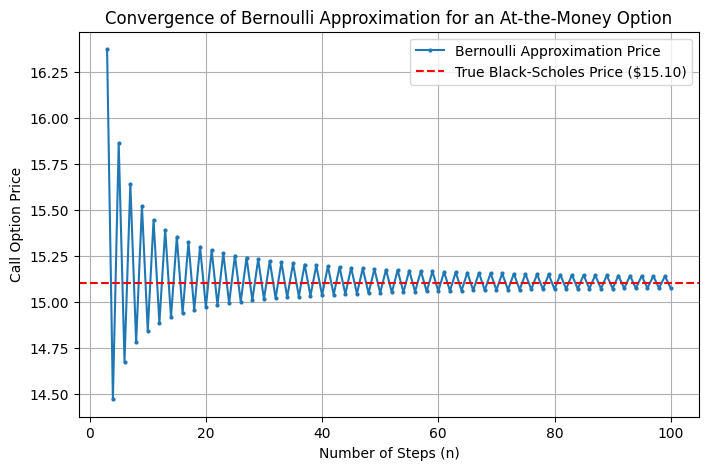

In [3]:
import matplotlib.pyplot as plt

S0 = 50.0
c = 50.0  # At-the-money: c = S0
t0 = 2.0
sigma = 0.5
rho = 0.035
true_price = black_scholes_call_price(S0, c, t0, rho, sigma)
n_values = range(3, 101)
approx_prices = []
for n in n_values:
    price = bernoulli_approximation_price(S0, c, t0, rho, sigma, n)
    approx_prices.append(price)
plt.figure(figsize=(8, 5))
plt.plot(n_values, approx_prices, label='Bernoulli Approximation Price', marker='.', linestyle='-', markersize=4)
plt.axhline(y=true_price, color='r', linestyle='--', label=f'True Black-Scholes Price (${true_price:.2f})')
plt.title('Convergence of Bernoulli Approximation for an At-the-Money Option')
plt.xlabel('Number of Steps (n)')
plt.ylabel('Call Option Price')
plt.legend()
plt.grid(True)
plt.show()

The approximation does not converge smoothly towards the true Black-Scholes value. Instead, the approximate price oscillates around the true value, overshooting it for odd values of $n$ and undershooting it for even values of $n$. The magnitude of these oscillations decreases as $n$ becomes larger, and the approximation gradually gets closer to the true price.

The model approximates the continuous random walk of a stock price with a discrete grid of possible future prices. The final payoff of the option, $\max(S_T - c, 0)$, is only calculated at these specific nodes at expiry. In our model, the log-price moves by $+g$ or $-g$ at each step. After $n$ steps, the final log-price will be $\log(S_0) + (2j - n)g$, where $j$ is the number of upward moves.

When $n$ is even, it is possible for the number of up moves to equal the number of down moves $j = n/2$. In this case, the central path ends exactly at the initial stock price $S_0$. Since we are in an at-the-money scenario $c = S_0$, this central node has a payoff of $\max(S_0 - c, 0) = 0$.

When $n$ is odd, the number of up moves can never equal the number of down moves. The term $(2j - n)$ will always be an odd number, so it can never be zero. This means that none of the final stock price nodes can land exactly on the strike price $c$. The two central-most paths will end slightly above and slightly below $c$, resulting in one node having a small positive payoff and the other having a zero payoff.

This structural difference between odd and even $n$ introduces a bias. The model with an odd number of steps tends to average final payoffs that are slightly higher than the model with an even number of steps, which has a final node with a zero payoff exactly at the strike price. As $n$ increases, the grid of possible outcomes becomes finer, the size of the oscillations diminishes, and the approximation converges to the true Black-Scholes price.

In numerical analysis, when an approximation method converges to a true value, its error often follows a power law relationship with the number of steps $n$. This relationship can be expressed as
\begin{equation}
    E(n) \approx C n^k
\end{equation}
where $E(n)$ is the absolute difference between the approximate and true values for $n$ steps, $C$ is a constant and $k$ is the order of convergence. For standard binomial models, the theoretical rate of convergence is known to be $O(1/n)$ or $k=1$.

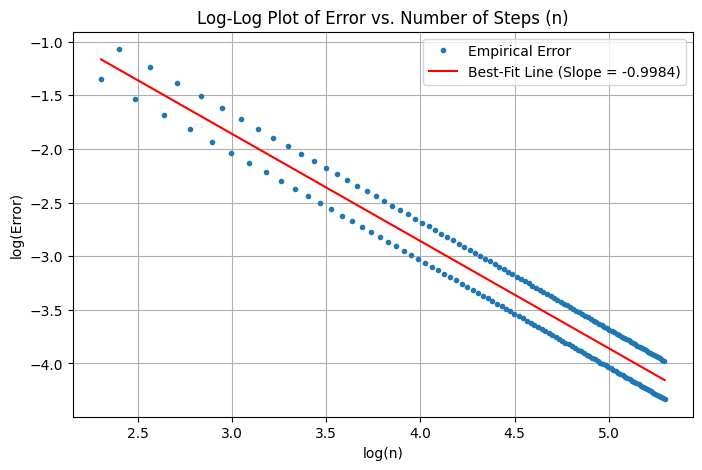

In [4]:
S0, c, t0, sigma, rho = 50.0, 50.0, 2.0, 0.5, 0.035
true_price = black_scholes_call_price(S0, c, t0, rho, sigma)
n_values = np.arange(10, 201)
errors = []
for n in n_values:
    approx_price = bernoulli_approximation_price(S0, c, t0, rho, sigma, n)
    errors.append(abs(approx_price - true_price) + 1e-12)

log_n = np.log(n_values)
log_error = np.log(errors)
slope, intercept = np.polyfit(log_n, log_error, 1)
plt.figure(figsize=(8, 5))
plt.plot(log_n, log_error, 'o', markersize=3, label='Empirical Error')
plt.plot(log_n, slope * log_n + intercept, 'r-', label=f'Best-Fit Line (Slope = {slope:.4f})')
plt.title('Log-Log Plot of Error vs. Number of Steps (n)')
plt.xlabel('log(n)')
plt.ylabel('log(Error)')
plt.legend()
plt.grid(True)
plt.show()